In [1]:
import os
import tqdm
import seaborn as sns

import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset

# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k

%matplotlib inline
SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

/Users/yukino/opt/anaconda3/envs/Pytorch-cpu/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
main_dir = "./dataset"
user = pd.read_csv(main_dir+"/user.csv")
item = pd.read_csv(main_dir+"/item.csv", dtype={'article_id': int})
transaction = pd.read_csv(main_dir+'/transaction.csv', parse_dates=['t_dat'])

In [3]:
transaction['t_dat'] = pd.to_datetime(transaction['t_dat'])
last_date = transaction['t_dat'].max()
first_date = transaction['t_dat'].min()
print(first_date,last_date)

2019-09-01 00:00:00 2020-09-22 00:00:00


In [5]:
transaction

,t_dat,customer_id,price,sales_channel_id,item_id,article_id,count
0,2019-09-01,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,0.016932,1,727880001,"[727880001, 767869001, 717490010, 547780022, 8...",24
1,2019-09-01,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,0.008458,1,767869001,"[727880001, 767869001, 717490010, 547780022, 8...",24
2,2019-09-01,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,0.008458,1,717490010,"[727880001, 767869001, 717490010, 547780022, 8...",24
3,2019-09-01,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,0.025407,1,547780022,"[727880001, 767869001, 717490010, 547780022, 8...",24
4,2019-11-16,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,0.022017,1,817953001,"[727880001, 767869001, 717490010, 547780022, 8...",24
...,...,...,...,...,...,...,...
12752551,2020-09-22,fe99a0069d6b3c64c2707d0ce53b9311540917471d82df...,0.033881,2,867969003,"[867969008, 562245001, 867969003, 682550002, 5...",7
12752552,2020-09-22,fe99a0069d6b3c64c2707d0ce53b9311540917471d82df...,0.033881,2,682550002,"[867969008, 562245001, 867969003, 682550002, 5...",7
12752553,2020-09-22,fe99a0069d6b3c64c2707d0ce53b9311540917471d82df...,0.023712,2,562245018,"[867969008, 562245001, 867969003, 682550002, 5...",7
12752554,2020-09-22,fe99a0069d6b3c64c2707d0ce53b9311540917471d82df...,0.042356,2,816598018,"[867969008, 562245001, 867969003, 682550002, 5...",7


In [4]:
transaction = transaction.drop(['article_id','count'],axis=1)

In [5]:
# calculate week number
transaction['week'] = (last_date - pd.to_datetime(transaction['t_dat'])).dt.days // 7

In [11]:
recall_weeks = [0,1,2,3,4]
week_nums = 4

In [32]:
def extract_history_orders(df, current_week=0):
  
    current_week_customers = df[df['week'] == current_week]['customer_id'].unique()
   
    history_orders = df[(df['week'] > current_week) & (df['customer_id'].isin(current_week_customers))]

    history_orders = history_orders.groupby('customer_id')['item_id'].apply(set).reset_index(name='history_order')
   
    history_orders = history_orders[['customer_id', 'history_order']]
    
    return history_orders

result_df = extract_history_orders(transaction)




In [34]:
result_df.to_parquet('./dataset/history.pt')

# build dataset

In [6]:
def concat_ids(x):
  
    label = list(x['label'])  
    img_prediction = list(x['img_prediction'])[:25]
    word_prediction = list(x['word_prediction'])[:25]
    cf_candidates = list(x['cf_candidates'])[:25]
   
    label.extend(img_prediction)
    label.extend(word_prediction)
    label.extend(cf_candidates)
    label = [int(item) for item in label]
  
    return list(set(label))


In [8]:
recall_weeks = [4]

In [19]:

def load_features_from_parquet(parquet_dir, start_week=0, end_week=4):
  
    filenames = [f'recall_CF_week{week}.pt' for week in range(start_week, end_week + 1)]
    
  
    parquet_files = [os.path.join(parquet_dir, f) for f in filenames]
   
    df = pd.concat([pd.read_parquet(f) for f in parquet_files if os.path.exists(f)])
    
    return df

df = load_features_from_parquet('/Users/yukino/Documents/course/csc522/project/code/rec-hm/data/')


In [20]:
def create_cf_candidates(row):
    user_cf = row['prediction_userCF'].split()
    item_cf = row['prediction_itemCF'].split()
    user_item_cf = row['prediction_user-itemCF'].split()
    combined = user_cf[:25] + item_cf[:25] + user_item_cf[:25]
    unique_combined = list(set(combined))
    
    return unique_combined

df['cf_candidates'] = df.apply(create_cf_candidates, axis=1)


In [22]:
def create_cf1_candidates(row):
    cf = row.split()
    unique_combined = list(set(cf[:25]))
    
    return unique_combined

df['usercf_candidates'] = df['prediction_userCF'].apply(create_cf1_candidates)
df['itemcf_candidates'] = df['prediction_itemCF'].apply(create_cf1_candidates)
df['uicf_candidates'] = df['prediction_user-itemCF'].apply(create_cf1_candidates)


In [9]:
df = df[['customer_id','week','cf_candidates']]

In [24]:
df = df[['customer_id','week','usercf_candidates','itemcf_candidates'	,'uicf_candidates']]

In [26]:
data_emb = []
for week in recall_weeks:
    #word
    word_set = pd.read_parquet(f"./fea_word_result/word_recall_week_{week}.pt")
    word_set['user_word_embedding'] = word_set['user_embedding']
    word_set['word_prediction'] = word_set['prediction']
    word_set = word_set.drop(['user_embedding','prediction'],axis=1)
    #image
    image_set = pd.read_parquet(f"./fea_img_result/img_recall_week_{week}.pt")
    image_set['user_img_embedding'] = image_set['user_embedding']
    image_set['img_prediction'] = image_set['prediction']
    image_set = image_set.drop(['user_embedding','prediction','user_img_embedding'],axis=1)
    dataset = image_set.merge(word_set[['customer_id','word_prediction']],on='customer_id')
    data_emb.append(dataset)
    #label_set.to_parquet(f'./dataset/recall_CF_week{week}.pt')
    
    

In [27]:
df_emb = pd.concat(data_emb)

In [28]:
dataset = df_emb.merge(df,on=['customer_id','week'])

In [29]:
dataset.head(2)

,customer_id,week,label,img_prediction,word_prediction,usercf_candidates,itemcf_candidates,uicf_candidates
0,00201f34c8c92683263346d78c2b45ffd0c6927229542d...,0,"[903926001, 909320002]","[701057007, 658495001, 807241066, 807241016, 9...","[767133001, 556677011, 556677010, 898885002, 7...","[823518001, 817361006, 857570001, 855249007, 8...","[821745001, 691463002, 876204001, 701303002, 8...","[857842007, 594542026, 736198029, 617675001, 4..."
1,0095d511bfb065ca851e45bd170619cf8c9f724c68e762...,0,"[673677026, 906296003, 797710004, 881570005, 8...","[824748001, 913220002, 910277001, 855110004, 8...","[814230002, 814230001, 907973001, 888343003, 9...","[816841006, 817361006, 858052007, 857570001, 8...","[828499001, 715624012, 632432001, 868042001, 5...","[664074030, 716654007, 664074072, 887904003, 6..."


In [30]:
dataset.to_parquet('./dataset/recall.pt')

In [50]:
dataset['candidates'] = dataset[['label','img_prediction','word_prediction','cf_candidates']].apply(concat_ids,axis=1)

In [51]:
dataset = dataset.drop(['img_prediction','word_prediction','cf_candidates'],axis=1)

In [52]:
dataset['len'] = dataset['candidates'].apply(lambda x:len(x))

In [54]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.8, n_splits=1, random_state=42)

groups = dataset['customer_id'].astype(str) + "_" + dataset['week'].astype(str)

for train_idx, test_idx in gss.split(df, groups=groups):
    df_reduced = dataset.iloc[train_idx]


In [57]:
from tqdm.notebook import tqdm
tqdm.pandas()

def expand_candidates_and_create_gt(df):
  
    exploded_df = df.explode('candidates')

    def is_label(x):
        labels, candidate = x
  
        if candidate in labels:
            return 1
        else:
            return 0
    
    exploded_df['gt'] = exploded_df[['label','candidates']].progress_apply(is_label, axis=1)
  
    exploded_df.rename(columns={'candidates': 'item'}, inplace=True)
    
    return exploded_df

In [59]:
df = expand_candidates_and_create_gt(df_reduced)

  0%|          | 0/4558141 [00:00<?, ?it/s]

In [60]:
df['label'] = df['gt']
df = df.drop(['len','gt'],axis=1)

In [61]:
df['item_id'] = df['item'].astype(int)

In [62]:
df.to_parquet('./dataset/dataset.pt')

# Feature Engineering

In [62]:
df = pd.read_parquet('./dataset.pt')

In [51]:
df.shape

(2765650, 44)

In [213]:
user = pd.read_csv(main_dir+"/user.csv")

In [9]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
user['age'] = pd.cut(user['age'], listBin)

In [10]:
from sklearn.preprocessing import LabelEncoder
def process_user_features(df):
    df['Active'] = df['Active'].fillna(0.0)
    df['FN'] = df['FN'].fillna(0.0)
    #df = df.fillna("0")
    df = df.astype(str)
    # Initialize a label encoder for postal codes
    label_encoder = LabelEncoder()

    # Apply label encoding to postal_code
    df['age'] = label_encoder.fit_transform(df['age'])
    df['fashion_news_frequency'] = label_encoder.fit_transform(df['fashion_news_frequency'])
    df['club_member_status'] = label_encoder.fit_transform(df['club_member_status'])
    df['postal_code'] = label_encoder.fit_transform(df['postal_code'])
    #df = df.astype(str)
    return df

# Apply the function to the user dataframe
processed_user_df = process_user_features(user)

In [11]:
processed_user_df.groupby('club_member_status').count()

,customer_id,FN,Active,fashion_news_frequency,age,postal_code
club_member_status,,,,,,
0,580445,580445,580445,580445,580445,580445
1,124,124,124,124,124,124
2,12743,12743,12743,12743,12743,12743
3,1069,1069,1069,1069,1069,1069


In [63]:
df = df.merge(processed_user_df,on='customer_id',how='left')

In [13]:

item_cat = ["product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
     ]
def process_item_features(df):

    df = df.astype(str)
    df = df.fillna("0")
    # Initialize a label encoder for postal codes
    label_encoder = LabelEncoder()

    # Apply label encoding to postal_code
    for fea in item_cat:
        df[fea] = label_encoder.fit_transform(df[fea])
    return df

# Apply the function to the user dataframe
processed_item_df = process_item_features(item)

In [233]:
processed_item_df.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,11,Vest top,7,16,Solid,45,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,11,Vest top,7,16,Solid,2,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [14]:
processed_item_df['article_id'] = processed_item_df['article_id'].astype(int)

In [15]:
item_cat_col = item_cat = ["article_id","product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
     ]

In [64]:
df = df.merge(processed_item_df[item_cat_col],left_on='item_id',right_on='article_id',how='left')

In [17]:
df

,customer_id,week,label,item_id,sales_after_week_1,monthly_sales_after_week_1_to_4,weekly_sale_trend_normalized,monthly_sale_trend_normalized,i_week4_repurchase_rate,i_week12_repurchase_rate,...,fashion_news_frequency,age,postal_code,article_id,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id
0,0130fa846141d8d21422187219af10b41cbb0b8daba887...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,1,2,12420,755754002,28,6,16,38,2,11
1,0d405f8ae8261ba8b848c8905aaaa60da49295fbaf4594...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,1,1,193858,755754002,28,6,16,38,2,11
2,8e3b5390d28a3df95f56a7dd6e4266aa7368c8538d9b68...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,2,1,216403,755754002,28,6,16,38,2,11
3,582549e69a387187231567d44e5d6862c292bb0598373b...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,1,3,49419,755754002,28,6,16,38,2,11
4,b4b30e6eab3884821f293c076f3a55d3223c7033fe60da...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,1,3,32891,755754002,28,6,16,38,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765645,00c46f6f5b21b977738f783ead8cb74881cdc90a424956...,4,1,540334017,0.0,0.0,1.617416e-09,4.931118e-10,0.000000,0.000000,...,2,3,149705,540334017,28,6,16,19,4,13
2765646,0fe4a3f068f7fb41eb9ba457b49fc427cf81fdab9b6e15...,4,1,901818004,0.0,0.0,1.617416e-09,4.931118e-10,0.000000,0.000000,...,1,3,229722,901818004,10,7,16,5,2,1
2765647,0fe4a3f068f7fb41eb9ba457b49fc427cf81fdab9b6e15...,4,1,910564001,0.0,0.0,1.617416e-09,4.931118e-10,0.000000,0.000000,...,1,3,229722,910564001,51,13,16,45,4,15
2765648,3e99fcfb48761821d91a12106d734342227c02d2631631...,4,1,825564005,0.0,0.0,1.617416e-09,4.931118e-10,0.000000,0.000000,...,1,4,255731,825564005,12,7,16,2,3,19


In [18]:

from typing import List
def time_interval(
    trans: pd.DataFrame,
    groupby_cols: List[str],
    unique: bool = False,
    step: int = 0
) -> pd.DataFrame:

    tmp_inter = trans[["customer_id", *groupby_cols, "t_dat"]]
    tmp_inter["t_dat"] = pd.to_datetime(tmp_inter["t_dat"])

    if unique:
        tmp_inter = tmp_inter.drop_duplicates(["customer_id", *groupby_cols])
  
    tmp_inter["last_purchase_date"] = tmp_inter.groupby(["customer_id", *groupby_cols])["t_dat"].shift(1)
    tmp_inter["last_purchase_interval"] = (tmp_inter["t_dat"] - tmp_inter["last_purchase_date"]).dt.days
    tmp_inter["last_purchase_interval"] = tmp_inter["last_purchase_interval"].fillna(-1).astype(int)  # Fill missing values with -1

    return tmp_inter["last_purchase_interval"].values.astype(int)

In [20]:
transaction["last_purchase_interval"] = time_interval(
    transaction, ["item_id"]
)

/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_67348/867159456.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_inter["t_dat"] = pd.to_datetime(tmp_inter["t_dat"])
/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_67348/867159456.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_inter["last_purchase_date"] = tmp_inter.groupby(["customer_id", *groupby_cols])["t_dat"].shift(1)
/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_67348/867159456.py:34: SettingWithCopyW

In [41]:
item_last_purchase_interval = transaction[(transaction['week']<=4)].drop_duplicates(['item_id','week'])

In [55]:
item_last_purchase_interval = item_last_purchase_interval[['item_id','week','last_purchase_interval']]

In [65]:
df = df.merge(item_last_purchase_interval,on=['item_id','week'])

In [22]:
from typing import List
from tqdm import tqdm

def repurchase_ratio(
    trans: pd.DataFrame, groupby_cols: List, week_num: int = 6
) -> np.ndarray:
    tmp_l = []
    for week in tqdm(range(1, week_num+1)):
        tmp_df = trans[trans["week"] >= week]
        # * Article re-purchase ratio
        item_user_sale = (
            tmp_df.groupby(["customer_id", *groupby_cols])
            .size()
            .reset_index(name="_SALE")
        )
        item_sale = (
            item_user_sale.groupby(groupby_cols).size().reset_index(name="_I_SALE")
        )
        item_user_sale = (
            item_user_sale[item_user_sale["_SALE"] > 1]  # * purchase more than once
            .groupby(groupby_cols)
            .size()
            .reset_index(name="_MULTI_SALE")
        )
        item_sale = item_sale.merge(item_user_sale, on=groupby_cols, how="left")
        item_sale["_RATIO"] = item_sale["_MULTI_SALE"] / (item_sale["_I_SALE"] + 1e-6)
        item_sale = item_sale[[*groupby_cols, "_RATIO"]]
        item_sale["week"] = week
        tmp_l.append(item_sale)

    df = trans[["week", *groupby_cols]]
    item_sale = pd.concat(tmp_l, ignore_index=True)
    df = df.merge(item_sale, on=["week", *groupby_cols], how="left")
    df["_RATIO"] = df["_RATIO"].fillna(0)
    return df["_RATIO"].values

In [23]:

item['article_id'] = item['article_id'].astype('int')
transaction = transaction.merge(item[["product_code","article_id"]], left_on = 'item_id',right_on="article_id", how="left")

In [24]:
from typing import List
import pandas as pd
import numpy as np
from tqdm import tqdm

def repurchase_ratio(trans: pd.DataFrame, groupby_cols: List, week_num_cal: int = 5, week_num_range: int = 10) -> np.ndarray:
    tmp_l = []
  
   # week_to = max(week_to, week_num)
    for week in tqdm(range(0, week_num_cal)):
        tmp_df = trans[(trans["week"] > week) & (trans["week"] <= week + week_num_range)]
        # Calculate re-purchase ratio
        item_user_sale = (
            tmp_df.groupby(["customer_id", *groupby_cols])
            .size()
            .reset_index(name="_SALE")
        )
        item_sale = (
            item_user_sale.groupby(groupby_cols).size().reset_index(name="_I_SALE")
        )
        item_user_sale = (
            item_user_sale[item_user_sale["_SALE"] > 1]  # purchases more than once
            .groupby(groupby_cols)
            .size()
            .reset_index(name="_MULTI_SALE")
        )
        item_sale = item_sale.merge(item_user_sale, on=groupby_cols, how="left")
        item_sale["_RATIO"] = item_sale["_MULTI_SALE"] / (item_sale["_I_SALE"] + 1e-6)
        item_sale = item_sale[[*groupby_cols, "_RATIO"]]
        item_sale["week"] = week
        tmp_l.append(item_sale)

    df = trans[["week", *groupby_cols]]
    item_sale = pd.concat(tmp_l, ignore_index=True)
    df = df.merge(item_sale, on=["week", *groupby_cols], how="left")
    df["_RATIO"] = df["_RATIO"].fillna(0)
    return df["_RATIO"].values


In [25]:
weeks = [4,12,24,50]
for week in weeks:
    transaction[f'i_week{week}_repurchase_rate'] = repurchase_ratio(transaction, ["article_id"], 5, week)

100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


In [26]:
transaction['valid'] = 1

In [22]:
transaction.head(2)

,t_dat,customer_id,price,sales_channel_id,item_id,week,product_code,article_id,i_week4_repurchase_rate,i_week12_repurchase_rate,i_week24_repurchase_rate,i_week50_repurchase_rate,valid
0,2019-09-01,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,0.016932,1,727880001,55,727880,727880001,0.0,0.0,0.0,0.0,1
1,2019-09-01,000f7535bdc611ad136a9f04746d6b1431f50a7f60fbbe...,0.008458,1,767869001,55,767869,767869001,0.0,0.0,0.0,0.0,1


In [27]:
weekly_sales = transaction.groupby(['item_id', 'week'])['valid'].sum().reset_index(name='weekly_sales')

In [29]:

for i in range(1, 3):  
    weekly_sales[f'sales_after_week_{i}'] = weekly_sales.groupby(['item_id'])['weekly_sales'].shift(-i)

for i in range(1, 3): 
    weekly_sales[f'monthly_sales_after_week_{i}_to_{i+3}'] = weekly_sales.groupby(['item_id'])['weekly_sales'].shift(-i) \
        + weekly_sales.groupby(['item_id'])['weekly_sales'].shift(-(i+1)) \
        + weekly_sales.groupby(['item_id'])['weekly_sales'].shift(-(i+2)) \
        + weekly_sales.groupby(['item_id'])['weekly_sales'].shift(-(i+3))


In [30]:
weekly_sales = weekly_sales.fillna(0.0)

In [58]:
df2 = df.merge(weekly_sales,on=['item_id','week'])

In [59]:
df2.shape

(2765650, 63)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def calculate_normalized_trend(sales_current, sales_previous):
    
    trend = (sales_current - sales_previous) / (sales_previous + 1e-6)
   
    trend_array = trend.values.reshape(-1, 1)
    
    normalized_trend = scaler.fit_transform(trend_array)
  
    return pd.Series(normalized_trend.flatten(), index=trend.index)

df['weekly_sale_trend_normalized'] = calculate_normalized_trend(df['sales_after_week_1'], df['sales_after_week_2'])

df['monthly_sale_trend_normalized'] = calculate_normalized_trend(df['monthly_sales_after_week_1_to_4'], df['monthly_sales_after_week_2_to_5'])



In [74]:
transaction['item_id'] = transaction['article_id']

In [91]:
transaction['item_id'] = transaction['item_id'].astype(int)

In [92]:
transaction = transaction[transaction['week']<=4]

In [95]:
transaction = transaction.drop_duplicates(['week','item_id'])

In [100]:
df = df.merge(transaction[['item_id','week','i_week4_repurchase_rate','i_week12_repurchase_rate','i_week24_repurchase_rate','i_week50_repurchase_rate']],on=['week','item_id'],how='left')
df = df.drop(['item','weekly_sales','sales_after_week_2','monthly_sales_after_week_2_to_5'],axis=1)

# add embedding features

In [79]:
df.head(2)

,customer_id,week,label,user_img_embedding,user_word_embedding,item,u_i_1,u_i_2,u_i_3,u_i_4,...,u_w_23,u_w_24,u_w_25,u_w_26,u_w_27,u_w_28,u_w_29,u_w_30,u_w_31,u_w_32
0,002156b708c7c6dd8afe31a743131d13b1e5dcbf2ce8c4...,4,0,"[-0.2907887, 0.30698544, -0.14043331, 0.202867...","[-0.04093735, 0.004139971, 0.08616687, 0.03055...",828928001,-0.290789,0.306985,-0.140433,0.202868,...,0.069826,0.024358,0.055965,-0.017413,0.058513,0.021392,0.039291,0.020856,0.00344,0.017415
0,002156b708c7c6dd8afe31a743131d13b1e5dcbf2ce8c4...,4,0,"[-0.2907887, 0.30698544, -0.14043331, 0.202867...","[-0.04093735, 0.004139971, 0.08616687, 0.03055...",579541001,-0.290789,0.306985,-0.140433,0.202868,...,0.069826,0.024358,0.055965,-0.017413,0.058513,0.021392,0.039291,0.020856,0.00344,0.017415


In [104]:
feas = []

In [105]:
for i in range(32):
    column_name_ui = f'u_i_{i+1}'
    feas.append(column_name_ui)

In [106]:

img_emb_len = len(df['user_img_embedding'].iloc[0])  
for i in range(img_emb_len):
    column_name = f'u_i_{i+1}'
    df[column_name] = df['user_img_embedding'].apply(lambda x: x[i])


In [113]:
df.groupby('label').count()

,customer_id,week,item_id,sales_after_week_1,monthly_sales_after_week_1_to_4,weekly_sale_trend_normalized,monthly_sale_trend_normalized,i_week4_repurchase_rate,i_week12_repurchase_rate,i_week24_repurchase_rate,...,u_i_23,u_i_24,u_i_25,u_i_26,u_i_27,u_i_28,u_i_29,u_i_30,u_i_31,u_i_32
label,,,,,,,,,,,,,,,,,,,,,
0,2579495,2579495,2579495,2579495,2579495,2579495,2579495,2579495,2579495,2579495,...,2579495,2579495,2579495,2579495,2579495,2579495,2579495,2579495,2579495,2579495
1,186155,186155,186155,186155,186155,186155,186155,186155,186155,186155,...,186155,186155,186155,186155,186155,186155,186155,186155,186155,186155


In [108]:
df = df.drop(['user_img_embedding'],axis=1)

In [68]:
df = df.drop(['article_id'],axis=1)

In [28]:
df = pd.read_parquet('rec-hm/data/final_dataset.pt')

In [38]:
df.head(2)

,customer_id,week,label,item_id,sales_after_week_1,monthly_sales_after_week_1_to_4,weekly_sale_trend_normalized,monthly_sale_trend_normalized,i_week4_repurchase_rate,i_week12_repurchase_rate,...,fashion_news_frequency,age,postal_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,last_purchase_interval
0,0130fa846141d8d21422187219af10b41cbb0b8daba887...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,1,2,12420,28,6,16,38,2,11,-1
1,0d405f8ae8261ba8b848c8905aaaa60da49295fbaf4594...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,1,1,193858,28,6,16,38,2,11,-1


In [37]:
df.last_purchase_interval.describe()

count    2.765650e+06
mean     3.323126e+00
std      2.973339e+01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      3.820000e+02
Name: last_purchase_interval, dtype: float64

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('rec-hm/data/final_dataset.pt')

In [3]:
import lightgbm as lgb

In [4]:
params = {
    "objective": "lambdarank",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",#"map",
    "max_depth": 5,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
}

In [8]:
df[cat_feas] = df[cat_feas].astype(float)

In [9]:
df[cat_feas] = df[cat_feas].astype(int)

In [10]:
train = df[df['week']>1]
valid = df[df['week']==1]
test = df[df['week']==0]

In [11]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [12]:
train_group = train[["customer_id", "item_id", "week"]]
train_group = (train_group.groupby(["week", "customer_id"]).size().values)

In [13]:
valid_group = valid[["customer_id", "item_id"]]
valid_group = valid_group.groupby(["customer_id"]).size().values

In [14]:
feats = df.drop(['label', 'customer_id','week','item_id'], axis=1).columns

In [78]:
feats

Index(['sales_after_week_1', 'monthly_sales_after_week_1_to_4',
       'weekly_sale_trend_normalized', 'monthly_sale_trend_normalized',
       'i_week4_repurchase_rate', 'i_week12_repurchase_rate',
       'i_week24_repurchase_rate', 'i_week50_repurchase_rate', 'u_i_1',
       'u_i_2', 'u_i_3', 'u_i_4', 'u_i_5', 'u_i_6', 'u_i_7', 'u_i_8', 'u_i_9',
       'u_i_10', 'u_i_11', 'u_i_12', 'u_i_13', 'u_i_14', 'u_i_15', 'u_i_16',
       'u_i_17', 'u_i_18', 'u_i_19', 'u_i_20', 'u_i_21', 'u_i_22', 'u_i_23',
       'u_i_24', 'u_i_25', 'u_i_26', 'u_i_27', 'u_i_28', 'u_i_29', 'u_i_30',
       'u_i_31', 'u_i_32', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'product_type_no',
       'product_group_name', 'graphical_appearance_no', 'colour_group_code',
       'perceived_colour_value_id', 'perceived_colour_master_id',
       'last_purchase_interval'],
      dtype='object')

In [5]:
cat_feas = ['FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'product_type_no',
       'product_group_name', 'graphical_appearance_no', 'colour_group_code',
       'perceived_colour_value_id', 'perceived_colour_master_id']

In [6]:
num_feas = ['sales_after_week_1', 'monthly_sales_after_week_1_to_4',
       'weekly_sale_trend_normalized', 'monthly_sale_trend_normalized',
       'i_week4_repurchase_rate', 'i_week12_repurchase_rate',
       'i_week24_repurchase_rate', 'i_week50_repurchase_rate', 'u_i_1',
       'u_i_2', 'u_i_3', 'u_i_4', 'u_i_5', 'u_i_6', 'u_i_7', 'u_i_8', 'u_i_9',
       'u_i_10', 'u_i_11', 'u_i_12', 'u_i_13', 'u_i_14', 'u_i_15', 'u_i_16',
       'u_i_17', 'u_i_18', 'u_i_19', 'u_i_20', 'u_i_21', 'u_i_22', 'u_i_23',
       'u_i_24', 'u_i_25', 'u_i_26', 'u_i_27', 'u_i_28', 'u_i_29', 'u_i_30',
       'u_i_31', 'u_i_32','last_purchase_interval']

In [17]:
feats = cat_feas +  num_feas

In [15]:
def train_rank_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_feas,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_feas,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=1000,
        valid_sets=[valid_set],
        early_stopping_rounds=150,
        verbose_eval=10,
    )
    return ranker

In [18]:
train = train[feats+['label']]
valid = valid[feats+['label']]

In [19]:
ranker = train_rank_model(train, valid, train_group, valid_group)

/Users/yukino/opt/anaconda3/envs/Pytorch-cpu/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/yukino/opt/anaconda3/envs/Pytorch-cpu/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/yukino/opt/anaconda3/envs/Pytorch-cpu/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/yukino/opt/anacon

Training until validation scores don't improve for 150 rounds
[10]	valid_0's map@12: 0.362848
[20]	valid_0's map@12: 0.360061
[30]	valid_0's map@12: 0.363527
[40]	valid_0's map@12: 0.364542
[50]	valid_0's map@12: 0.365757
[60]	valid_0's map@12: 0.367347
[70]	valid_0's map@12: 0.369956
[80]	valid_0's map@12: 0.372268
[90]	valid_0's map@12: 0.374108
[100]	valid_0's map@12: 0.375154
[110]	valid_0's map@12: 0.375279
[120]	valid_0's map@12: 0.37697
[130]	valid_0's map@12: 0.378301
[140]	valid_0's map@12: 0.379156
[150]	valid_0's map@12: 0.379143
[160]	valid_0's map@12: 0.379188
[170]	valid_0's map@12: 0.379508
[180]	valid_0's map@12: 0.380366
[190]	valid_0's map@12: 0.381533
[200]	valid_0's map@12: 0.382216
[210]	valid_0's map@12: 0.38293
[220]	valid_0's map@12: 0.383003
[230]	valid_0's map@12: 0.382846
[240]	valid_0's map@12: 0.382951
[250]	valid_0's map@12: 0.383637
[260]	valid_0's map@12: 0.38386
[270]	valid_0's map@12: 0.384455
[280]	valid_0's map@12: 0.384639
[290]	valid_0's map@12: 0.

In [ ]:
from typing import Iterable
import numpy as np


def _ap_at_k(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if actual is None:
        return 0.0

    return score / min(len(actual), k)

def map_at_k(actual: Iterable, predicted: Iterable, k: int = 12) -> float:
    """Compute mean average precision @ k.

    Parameters
    ----------
    actual : Iterable
        Label.
    predicted : Iterable
        Predictions.
    k : int, optional
        k, by default ``12``.

    Returns
    -------
    float
        MAP@k.
    """
    return np.mean(
        [_ap_at_k(a, p, k) for a, p in zip(actual, predicted) if a is not None]
    )


In [20]:
import numpy as np

def apk(actual, predicted, k=12):
    """
    Computes the average precision at k between two lists of items.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=12):
    """
    Computes the mean average precision at k.
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

predictions = ranker.predict(test[feats])


/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_22886/3387596078.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


MAP@12: 0.13623974882012346


In [60]:
test['predictions'] = predictions
test_sorted = test.sort_values(['customer_id', 'predictions'], ascending=[True, False])
grouped = test_sorted.groupby('customer_id')

actual = grouped['label'].apply(list)
predicted = grouped.apply(lambda df: df.nlargest(5, 'predictions')['label'].tolist())

map5 = mapk(actual, predicted, k=5)
print(f"MAP@5: {map5}")


MAP@5: 0.31870903612586593


In [100]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)


In [101]:
feat_importance

,feature,importance
5,postal_code,6672
12,sales_after_week_1,3255
6,product_type_no,1983
9,colour_group_code,1398
14,weekly_sale_trend_normalized,1246
15,monthly_sale_trend_normalized,920
13,monthly_sales_after_week_1_to_4,876
8,graphical_appearance_no,539
19,i_week50_repurchase_rate,524
16,i_week4_repurchase_rate,516


In [117]:
test['model1_outputs'] = ranker.predict(test[feats])

/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_67348/4136028430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['model1_outputs'] = ranker.predict(test[feats])


In [118]:
output1 = test[['customer_id','label','item_id','model1_outputs']]

In [120]:
output1

,customer_id,label,item_id,model1_outputs
0,0130fa846141d8d21422187219af10b41cbb0b8daba887...,0,755754002,-1.500991
1,0d405f8ae8261ba8b848c8905aaaa60da49295fbaf4594...,0,755754002,-1.505613
2,8e3b5390d28a3df95f56a7dd6e4266aa7368c8538d9b68...,0,755754002,-2.080189
3,582549e69a387187231567d44e5d6862c292bb0598373b...,0,755754002,-1.447885
4,b4b30e6eab3884821f293c076f3a55d3223c7033fe60da...,0,755754002,-1.506437
...,...,...,...,...
495496,e5f71a8be841c4491fad49a0a9fa86d67477cfc7dda13a...,1,493810014,-1.128831
495497,27f09e5ddeca687a350d2352f982c55be89ba673f1aa78...,1,796793001,-1.282522
495498,796063f730a4ffa317f5e7a7f52e426dd39cdb91f56e14...,0,905853001,-0.964701
495499,a5795226cbde2ed2261927b221d7f0105895721f2f0354...,1,913272001,4.604580


In [23]:
params2 = {
    "objective": "binary",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "auc",#"map",
    "max_depth": 6,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
}

In [24]:
def train_binary_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_feas,
        params=params2,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_feas,
        params=params2,
    )

    ranker = lgb.train(
        params2,
        train_set,
        num_boost_round=1000,
        valid_sets=[valid_set],
        early_stopping_rounds=150,
        verbose_eval=10,
    )
    return ranker

In [25]:
# ranker = train_rank_model(train, valid, train_group, valid_group)
binary_ranker = train_binary_model(train, valid, train_group, valid_group)

/Users/yukino/opt/anaconda3/envs/Pytorch-cpu/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/yukino/opt/anaconda3/envs/Pytorch-cpu/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/yukino/opt/anaconda3/envs/Pytorch-cpu/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/yukino/opt/anacon

Training until validation scores don't improve for 150 rounds
[10]	valid_0's auc: 0.788306
[20]	valid_0's auc: 0.793641
[30]	valid_0's auc: 0.797293
[40]	valid_0's auc: 0.801703
[50]	valid_0's auc: 0.80568
[60]	valid_0's auc: 0.809578
[70]	valid_0's auc: 0.813093
[80]	valid_0's auc: 0.816726
[90]	valid_0's auc: 0.820019
[100]	valid_0's auc: 0.822879
[110]	valid_0's auc: 0.825241
[120]	valid_0's auc: 0.827256
[130]	valid_0's auc: 0.828897
[140]	valid_0's auc: 0.830542
[150]	valid_0's auc: 0.832025
[160]	valid_0's auc: 0.83326
[170]	valid_0's auc: 0.8344
[180]	valid_0's auc: 0.835513
[190]	valid_0's auc: 0.836615
[200]	valid_0's auc: 0.837596
[210]	valid_0's auc: 0.83861
[220]	valid_0's auc: 0.83937
[230]	valid_0's auc: 0.840062
[240]	valid_0's auc: 0.840852
[250]	valid_0's auc: 0.841535
[260]	valid_0's auc: 0.842208
[270]	valid_0's auc: 0.842768
[280]	valid_0's auc: 0.843176
[290]	valid_0's auc: 0.843627
[300]	valid_0's auc: 0.844085
[310]	valid_0's auc: 0.844489
[320]	valid_0's auc: 0.

Model fusion

In [26]:
test['model2_outputs'] = binary_ranker.predict(test[feats])

/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_22886/579584392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['model2_outputs'] = binary_ranker.predict(test[feats])


In [27]:
from sklearn.metrics import roc_auc_score

test_probabilities = binary_ranker.predict(test[feats])

test_auc = roc_auc_score(test['label'], test_probabilities)

print(f"The AUC on the test set is: {test_auc}")


The AUC on the test set is: 0.8461303665954931


In [53]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve

In [58]:
test['y_pred'] = test['model2_outputs'].apply(lambda x: 1 if x>=0.2 else 0)

In [59]:
# 计算指标
f1 = f1_score(test['label'], test['y_pred'])
recall = recall_score(test['label'], test['y_pred'])
precision = precision_score(test['label'], test['y_pred'])
auc = roc_auc_score(test['label'], test['model2_outputs'])

# 打印指标
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'AUC: {auc:.2f}')

F1 Score: 0.39
Recall: 0.48
Precision: 0.33
AUC: 0.85


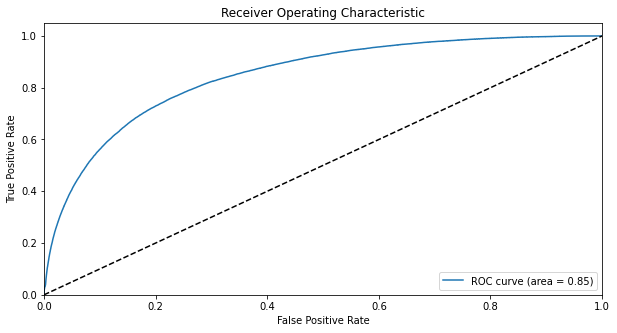

In [55]:
# ROC 
fpr, tpr, thresholds = roc_curve(test['label'], test['model2_outputs'])

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [51]:
test

,customer_id,week,label,item_id,sales_after_week_1,monthly_sales_after_week_1_to_4,weekly_sale_trend_normalized,monthly_sale_trend_normalized,i_week4_repurchase_rate,i_week12_repurchase_rate,...,postal_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,last_purchase_interval,predictions,model2_outputs
0,0130fa846141d8d21422187219af10b41cbb0b8daba887...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,12420,28,6,16,38,2,11,-1,-1.500991,0.032236
1,0d405f8ae8261ba8b848c8905aaaa60da49295fbaf4594...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,193858,28,6,16,38,2,11,-1,-1.505613,0.011321
2,8e3b5390d28a3df95f56a7dd6e4266aa7368c8538d9b68...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,216403,28,6,16,38,2,11,-1,-2.080189,0.009417
3,582549e69a387187231567d44e5d6862c292bb0598373b...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,49419,28,6,16,38,2,11,-1,-1.447885,0.013753
4,b4b30e6eab3884821f293c076f3a55d3223c7033fe60da...,0,0,755754002,5.0,56.0,6.484234e-10,4.931118e-10,0.227273,0.211111,...,32891,28,6,16,38,2,11,-1,-1.506437,0.028701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495496,e5f71a8be841c4491fad49a0a9fa86d67477cfc7dda13a...,0,1,493810014,1.0,0.0,1.661131e-03,4.931118e-10,0.000000,0.000000,...,245331,28,6,10,45,4,15,-1,-1.128831,0.060582
495497,27f09e5ddeca687a350d2352f982c55be89ba673f1aa78...,0,1,796793001,2.0,6.0,3.278543e-09,6.025210e-10,0.000000,0.000000,...,241600,45,11,16,45,4,15,-1,-1.282522,0.057784
495498,796063f730a4ffa317f5e7a7f52e426dd39cdb91f56e14...,0,0,905853001,1.0,0.0,1.661131e-03,4.931118e-10,0.000000,0.000000,...,81548,23,5,16,35,2,4,-1,-0.964701,0.082424
495499,a5795226cbde2ed2261927b221d7f0105895721f2f0354...,0,1,913272001,0.0,0.0,1.617416e-09,4.931118e-10,0.000000,0.000000,...,145416,10,7,16,5,2,1,-1,4.604580,0.979838


In [123]:
test['rank1'] = test.groupby('customer_id')['model1_outputs'].rank(method='first', ascending=False)
test['rank2'] = test.groupby('customer_id')['model2_outputs'].rank(method='first', ascending=False)


/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_67348/1337662569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rank1'] = test.groupby('customer_id')['model1_outputs'].rank(method='first', ascending=False)
/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_67348/1337662569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rank2'] = test.groupby('customer_id')['model2_outputs'].rank(method='first', ascending=False)


In [125]:
test['rank'] = (test['rank1'] + test['rank2']) / 2


/var/folders/t0/v5mt2fvx40j4y3x7fqgq6kg00000gn/T/ipykernel_67348/3876479801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rank'] = (test['rank1'] + test['rank2']) / 2


In [127]:
test = test[['customer_id','label','item_id','rank']]

In [128]:
test

,customer_id,label,item_id,rank
0,0130fa846141d8d21422187219af10b41cbb0b8daba887...,0,755754002,24.0
1,0d405f8ae8261ba8b848c8905aaaa60da49295fbaf4594...,0,755754002,29.5
2,8e3b5390d28a3df95f56a7dd6e4266aa7368c8538d9b68...,0,755754002,21.0
3,582549e69a387187231567d44e5d6862c292bb0598373b...,0,755754002,35.0
4,b4b30e6eab3884821f293c076f3a55d3223c7033fe60da...,0,755754002,19.5
...,...,...,...,...
495496,e5f71a8be841c4491fad49a0a9fa86d67477cfc7dda13a...,1,493810014,14.5
495497,27f09e5ddeca687a350d2352f982c55be89ba673f1aa78...,1,796793001,28.5
495498,796063f730a4ffa317f5e7a7f52e426dd39cdb91f56e14...,0,905853001,17.5
495499,a5795226cbde2ed2261927b221d7f0105895721f2f0354...,1,913272001,1.0


In [129]:
test.to_parquet('./dataset/result.pt')